#### Several works in the field of automatic tumor diagnosis can be divided into two main categories, namely feature extraction and sample classification. 
#### In general, the image properties are extracted first. These features usually include static features such as entropy, skewness, mean, energy, torque, and correlation or properties obtained by applying other algorithms

In [10]:
import numpy as np
import keras
import tensorflow as tf
import cv2
import os
import imutils
import shutil
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img

import os
import cv2
import numpy as np
from skimage import io, img_as_ubyte
from kapur import kapur_threshold

from matplotlib import pyplot as plt
from skimage import io, img_as_ubyte
from kapur import kapur_threshold

from PIL import Image
from tensorflow.keras.layers import Conv2D, Input, GlobalAveragePooling2D, ZeroPadding2D, BatchNormalization, Activation, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model, load_model, save_model

from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras import backend

from keras import applications
from keras.models import Sequential

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.optimizers import Adam

from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

### 0. Data Augmentation

In [3]:
def create_dir(newdir, empty = True):
    """
    create new folder if the target folder doesnt exist
    """
    CHECK_FOLDER = os.path.isdir(newdir)
    # If folder doesn't exist, then create it.
    if not CHECK_FOLDER:
        os.makedirs(newdir)
        print("created folder : ", newdir)

    else:
        if empty == True:
            ## whether to remove all contents in the current augmented data folder and generate new ones
            shutil.rmtree(newdir)
            print("current augmented data removed")
            os.makedirs(newdir)
        print(newdir, "folder already exists.")
        
## save the augmented data and the original ones in new folders        
def data_augmentation(refresh=True, num=5):
    """
    refresh: whether to replace current augmented data and generate new ones
    num: number of augmented data per image
    """

    training_path = "data\\Training"
    ## destination parent folder for augmented data
    augmented_path = "data\\augmentation_training"
    current_directory = os.getcwd()
    original_path = os.path.join(current_directory, training_path)
    augmented_path = os.path.join(current_directory, augmented_path)

    ## augmented data generator
    image_generator = ImageDataGenerator(rotation_range=90, shear_range=0.4, zoom_range=0,
                                         samplewise_center=True, vertical_flip=True, horizontal_flip=True,
                                         samplewise_std_normalization=True)
    for subf in os.listdir(original_path):
        new_dir = os.path.join(augmented_path, subf)
        create_dir(new_dir, empty=refresh)
        for f in os.listdir(os.path.join(original_path, subf)):
            image_path = os.path.join(original_path, subf, f)
            img = load_img(image_path)
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)  # reshape to (1, height, width, channels)
            i = 1
            for batch in image_generator.flow(x, batch_size=1,
                                              save_to_dir=new_dir,
                                              save_prefix=f.split(".")[0],
                                              save_format='jpg'):
                i += 1
                if i > num:
                    break

In [15]:
data_augmentation()

current augmented data removed
C:\Users\chenj\Desktop\project-JieChen\data\augmentation_training\glioma folder already exists.
created folder :  C:\Users\chenj\Desktop\project-JieChen\data\augmentation_training\meningioma
created folder :  C:\Users\chenj\Desktop\project-JieChen\data\augmentation_training\notumor
created folder :  C:\Users\chenj\Desktop\project-JieChen\data\augmentation_training\pituitary


### 1. Image Preprocessing

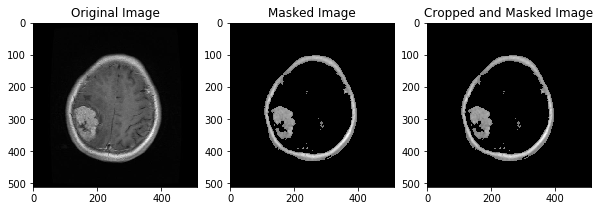

In [4]:
def blur_and_crop(image, blur = "median", cropping= False, kernel = 5, masking = True, plot=False):
    """
    preprocessing:
    1. convert to grayscale and blur the image using median or gaussian filter
    2. (optional)apply kapur thresholding to create a mask, mask the blurred image
    3. crop the image to contain only the brain image, leaving the blank around surrounding the brain out.
    """

    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    if blur == "median":
        blurred = cv2.medianBlur(gray, kernel)
    elif blur == "gaussian":
        blurred = cv2.GaussianBlur(gray, (kernel, kernel), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise

    if masking == True:
   ## creating mask with kapur thresholding
        threshold = kapur_threshold(blurred)
        binr = cv2.threshold(blurred, threshold, 255, cv2.THRESH_BINARY)[1]
        masked_image = cv2.bitwise_and(blurred, blurred, mask=binr)
    else:
        masked_image = blurred
        
    if cropping == True:
        thresh = cv2.threshold(masked_image, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # Find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)


        # Find the extreme points for cropping
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        # crop new image out of the original image using the four extreme points (left, right, top, bottom)
        cropped_image = masked_image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]      
    else:
        cropped_image = masked_image

    if plot:
        plt.figure(figsize=(10, 10))
        plt.subplot(131), plt.imshow(image, cmap='gray'), plt.title('Original Image')
        plt.subplot(132), plt.imshow(masked_image, cmap='gray'), plt.title('Masked Image')
        plt.subplot(133), plt.imshow(cropped_image, cmap='gray'), plt.title('Cropped and Masked Image')
        
        plt.show()
    

    return cropped_image

img = cv2.imread(r"C:\Users\chenj\Desktop\project-JieChen\data\Training\meningioma\Tr-me_0011.jpg")
new_img = blur_and_crop(img, blur = "median", cropping = False, kernel = 5, masking = True, plot=True)

In [5]:
training_path = "data\\Training"
"\\augmentation_".join(training_path.split("\\"))

'data\\augmentation_Training'

In [6]:
def preprocessing(training_path, masking=False, crop=False):
    """
    preprocess the images in training_path parent folder
    1. create a destination folder for preprocessed images
    2. blur, mask and (crop) the images, masking is optional.
    3. store the processed images in new folder
    4. 提取图像特征并保存特征向量
    
    parameter: 
    training_path: the folder name for the original images to be processed
    masking: if masking is applied in the processing
    """
    
    current_directory = os.getcwd()
    ## destination parent folder for processed data
    if masking == True:
        processed_path = "\\Processed_".join(training_path.split("\\"))
    else:
        processed_path = "\\Unmasked_Processed_".join(training_path.split("\\"))
    
    processed_path = os.path.join(current_directory, processed_path)
    original_path = os.path.join(current_directory, training_path)
    
    # 4. 提取图像特征并保存特征向量
    feature_extractor = VGG16(weights='imagenet', include_top=False, input_shape=(512, 512, 3))
    feature_extractor.trainable = False  # 冻结特征提取器的权重，只训练新加入的全连接层
    
    # 提取特征并保存特征向量
    features_list = []
    labels_list = []
    for subf in tqdm(os.listdir(original_path), desc="Folders"):
        new_dir = os.path.join(processed_path, subf)
        create_dir(new_dir, empty=True)

        for f in tqdm(os.listdir(os.path.join(original_path, subf)), desc="Images"):
            image_path = os.path.join(original_path, subf, f)
            img = cv2.imread(image_path)
            img = cv2.resize(img, (512, 512))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # VGG16使用RGB格式

            # 保存预处理后的图像
            new_img = blur_and_crop(img, blur="median", cropping=crop, kernel=5, masking=masking, plot=False)
            image = Image.fromarray(new_img)
            image.save(os.path.join(new_dir, f))

            # 提取特征
            features = feature_extractor.predict(np.expand_dims(img, axis=0))
            features_list.append(features.flatten())  # 将特征展平为向量
            labels_list.append(subf)  # 添加标签

    # 保存特征向量为Numpy数组
    features_array = np.array(features_list)
    np.save('features.npy', features_array)
    # 保存标签为Numpy数组
    labels_array = np.array(labels_list)
    np.save('labels.npy', labels_array)


FileNotFoundError: [Errno 2] No such file or directory: 'features.npy'

In [7]:
preprocessing(training_path="data\\Training", masking=False)
preprocessing(training_path="data\\Training", masking=True)
# 这里python会崩

Folders:   0%|                                                                                   | 0/4 [00:00<?, ?it/s]

current augmented data removed
C:\Users\chenj\Desktop\project-JieChen\data\Unmasked_Processed_Training\glioma folder already exists.



Images:   5%|███▌                                                                    | 65/1321 [00:55<18:12,  1.15it/s]


Images:  10%|███████                                                                | 131/1321 [01:55<17:51,  1.11it/s]


Images:  15%|██████████▌                                                            | 197/1321 [02:53<16:19,  1.15it/s]


Images:  20%|██████████████▏                                                        | 263/1321 [03:50<15:23,  1.15it/s]


Images:  25%|█████████████████▋                                                     | 329/1321 [04:50<15:39,  1.06it/s]


Images:  30%|█████████████████████▏                                                 | 395/1321 [05:51<16:10,  1.05s/it]


Images:  35%|████████████████████████▊                                              | 461/1321 [06:52<15:25,  1.08s/it]


Images:  40%|████████████████████████████▎                                          | 527/1321 [07:52<11:43,  1.13it/s]


Images:  45%|███████████████████████████████▊                                       | 593/1321 [08:53<10:46,  1.13it/s]


Images:  50%|███████████████████████████████████▍                                   | 659/1321 [09:52<09:48,  1.12it/s]


Images:  55%|██████████████████████████████████████▉                                | 725/1321 [10:51<08:50,  1.12it/s]


Images:  60%|██████████████████████████████████████████▌                            | 791/1321 [11:50<07:52,  1.12it/s]


Images:  65%|██████████████████████████████████████████████                         | 857/1321 [12:50<06:59,  1.11it/s]


Images:  70%|█████████████████████████████████████████████████▌                     | 923/1321 [13:50<06:02,  1.10it/s]


Images:  75%|█████████████████████████████████████████████████████▏                 | 989/1321 [14:51<05:04,  1.09it/s]


Images:  80%|███████████████████████████████████████████████████████▉              | 1055/1321 [15:51<03:58,  1.11it/s]


Images:  85%|███████████████████████████████████████████████████████████▍          | 1121/1321 [16:50<02:59,  1.12it/s]


Images:  90%|██████████████████████████████████████████████████████████████▉       | 1187/1321 [17:51<02:00,  1.12it/s]


Images:  95%|██████████████████████████████████████████████████████████████████▍   | 1253/1321 [18:51<01:01,  1.11it/s]


Images: 100%|█████████████████████████████████████████████████████████████████████▉| 1319/1321 [19:51<00:01,  1.09it/s]


Folders:  25%|██████████████████▎                                                      | 1/4 [19:53<59:41, 1193.85s/it]

current augmented data removed
C:\Users\chenj\Desktop\project-JieChen\data\Unmasked_Processed_Training\meningioma folder already exists.



Images:   5%|███▍                                                                    | 65/1339 [01:01<19:54,  1.07it/s]


Images:  10%|██████▉                                                                | 131/1339 [02:01<18:40,  1.08it/s]


Images:  15%|██████████▍                                                            | 197/1339 [03:01<17:16,  1.10it/s]


Images:  20%|█████████████▉                                                         | 263/1339 [04:02<16:45,  1.07it/s]


Images:  25%|█████████████████▍                                                     | 329/1339 [05:02<15:13,  1.11it/s]


Images:  29%|████████████████████▉                                                  | 395/1339 [06:03<15:29,  1.02it/s]


Images:  34%|████████████████████████▍                                              | 461/1339 [07:03<13:20,  1.10it/s]


Images:  39%|███████████████████████████▉                                           | 527/1339 [08:06<12:37,  1.07it/s]


Images:  44%|███████████████████████████████▍                                       | 593/1339 [09:07<11:23,  1.09it/s]


Images:  49%|██████████████████████████████████▉                                    | 659/1339 [10:09<10:26,  1.09it/s]


Images:  54%|██████████████████████████████████████▍                                | 725/1339 [11:14<10:12,  1.00it/s]


Images:  59%|█████████████████████████████████████████▉                             | 791/1339 [12:18<08:29,  1.08it/s]


Images:  64%|█████████████████████████████████████████████▍                         | 857/1339 [13:20<07:18,  1.10it/s]


Images:  69%|████████████████████████████████████████████████▉                      | 923/1339 [14:20<06:15,  1.11it/s]


Images:  74%|████████████████████████████████████████████████████▍                  | 989/1339 [15:20<05:18,  1.10it/s]


Images:  79%|███████████████████████████████████████████████████████▏              | 1055/1339 [16:23<04:20,  1.09it/s]


Images:  84%|██████████████████████████████████████████████████████████▌           | 1121/1339 [17:23<03:20,  1.09it/s]


Images:  89%|██████████████████████████████████████████████████████████████        | 1187/1339 [18:24<02:22,  1.07it/s]


Images:  94%|█████████████████████████████████████████████████████████████████▌    | 1253/1339 [19:25<01:18,  1.09it/s]


Images:  99%|████████████████████████████████████████████████████████████████████▉ | 1319/1339 [20:25<00:18,  1.11it/s]


Folders:  50%|████████████████████████████████████▌                                    | 2/4 [40:38<40:46, 1223.49s/it]

created folder :  C:\Users\chenj\Desktop\project-JieChen\data\Unmasked_Processed_Training\notumor



Images:   4%|██▉                                                                     | 65/1595 [00:59<23:15,  1.10it/s]


Images:   8%|█████▊                                                                 | 131/1595 [02:00<22:25,  1.09it/s]


Images:  12%|████████▊                                                              | 197/1595 [03:01<21:20,  1.09it/s]


Images:  16%|███████████▋                                                           | 263/1595 [04:03<20:34,  1.08it/s]


Images:  21%|██████████████▋                                                        | 329/1595 [05:04<19:14,  1.10it/s]


Images:  25%|█████████████████▌                                                     | 395/1595 [06:05<19:07,  1.05it/s]


Images:  29%|████████████████████▌                                                  | 461/1595 [07:05<17:17,  1.09it/s]


Images:  33%|███████████████████████▍                                               | 527/1595 [08:06<16:14,  1.10it/s]


Images:  37%|██████████████████████████▍                                            | 593/1595 [09:06<15:24,  1.08it/s]


Images:  41%|█████████████████████████████▎                                         | 659/1595 [10:07<15:01,  1.04it/s]


Images:  45%|████████████████████████████████▎                                      | 725/1595 [11:10<14:07,  1.03it/s]


Images:  50%|███████████████████████████████████▏                                   | 791/1595 [12:14<11:37,  1.15it/s]


Images:  54%|██████████████████████████████████████▏                                | 857/1595 [13:14<10:51,  1.13it/s]


Images:  58%|█████████████████████████████████████████                              | 923/1595 [14:11<09:31,  1.18it/s]


Images:  62%|████████████████████████████████████████████                           | 989/1595 [15:11<09:09,  1.10it/s]


Images:  66%|██████████████████████████████████████████████▎                       | 1055/1595 [16:11<08:04,  1.11it/s]


Images:  70%|█████████████████████████████████████████████████▏                    | 1121/1595 [17:11<07:15,  1.09it/s]


Images:  74%|████████████████████████████████████████████████████                  | 1187/1595 [18:13<06:15,  1.09it/s]


Images:  79%|██████████████████████████████████████████████████████▉               | 1253/1595 [19:14<05:15,  1.08it/s]


Images:  83%|█████████████████████████████████████████████████████████▉            | 1319/1595 [20:15<04:14,  1.08it/s]


Images:  87%|████████████████████████████████████████████████████████████▊         | 1385/1595 [21:16<03:13,  1.09it/s]


Images:  91%|███████████████████████████████████████████████████████████████▋      | 1451/1595 [22:17<02:15,  1.06it/s]


Images:  95%|██████████████████████████████████████████████████████████████████▌   | 1517/1595 [23:19<01:13,  1.06it/s]


Images:  99%|█████████████████████████████████████████████████████████████████████▍| 1583/1595 [24:19<00:10,  1.10it/s]


Folders:  75%|█████████████████████████████████████████████████████▎                 | 3/4 [1:05:08<22:16, 1336.42s/it]

created folder :  C:\Users\chenj\Desktop\project-JieChen\data\Unmasked_Processed_Training\pituitary



Images:   4%|███▏                                                                    | 65/1457 [01:01<21:34,  1.08it/s]


Images:   9%|██████▍                                                                | 131/1457 [02:02<20:54,  1.06it/s]


Images:  14%|█████████▌                                                             | 197/1457 [03:05<19:41,  1.07it/s]


Images:  18%|████████████▊                                                          | 263/1457 [04:07<18:17,  1.09it/s]


Images:  23%|████████████████                                                       | 329/1457 [05:07<17:05,  1.10it/s]


Images:  27%|███████████████████▏                                                   | 395/1457 [06:08<16:05,  1.10it/s]


Images:  32%|██████████████████████▍                                                | 461/1457 [07:08<15:17,  1.09it/s]


Images:  36%|█████████████████████████▋                                             | 527/1457 [08:09<14:08,  1.10it/s]


Images:  41%|████████████████████████████▉                                          | 593/1457 [09:10<13:04,  1.10it/s]


Images:  45%|████████████████████████████████                                       | 659/1457 [10:10<12:01,  1.11it/s]


Images:  50%|███████████████████████████████████▎                                   | 725/1457 [11:10<11:07,  1.10it/s]


Images:  54%|██████████████████████████████████████▌                                | 791/1457 [12:10<10:04,  1.10it/s]


Images:  59%|█████████████████████████████████████████▊                             | 857/1457 [13:11<09:06,  1.10it/s]


Images:  63%|████████████████████████████████████████████▉                          | 923/1457 [14:13<08:07,  1.09it/s]


Images:  68%|████████████████████████████████████████████████▏                      | 989/1457 [15:15<08:14,  1.06s/it]


Images:  72%|██████████████████████████████████████████████████▋                   | 1055/1457 [16:22<06:15,  1.07it/s]


Images:  77%|█████████████████████████████████████████████████████▊                | 1121/1457 [17:24<05:14,  1.07it/s]


Images:  81%|█████████████████████████████████████████████████████████             | 1187/1457 [18:27<04:44,  1.05s/it]


Images:  86%|████████████████████████████████████████████████████████████▏         | 1253/1457 [19:29<03:13,  1.06it/s]


Images:  91%|███████████████████████████████████████████████████████████████▎      | 1319/1457 [20:31<02:10,  1.06it/s]


Images:  95%|██████████████████████████████████████████████████████████████████▌   | 1385/1457 [21:33<01:13,  1.02s/it]


Images: 100%|█████████████████████████████████████████████████████████████████████▋| 1451/1457 [22:39<00:06,  1.04s/it]


Folders:   0%|                                                                                   | 0/4 [00:00<?, ?it/s]

created folder :  C:\Users\chenj\Desktop\project-JieChen\data\Processed_Training\glioma



Images:   5%|███▌                                                                    | 65/1321 [00:55<18:26,  1.13it/s]


Images:  10%|███████                                                                | 131/1321 [01:56<19:03,  1.04it/s]


Images:  15%|██████████▌                                                            | 197/1321 [02:56<16:58,  1.10it/s]


Images:  20%|██████████████▏                                                        | 263/1321 [03:56<15:41,  1.12it/s]


Images:  25%|█████████████████▋                                                     | 329/1321 [04:55<14:58,  1.10it/s]


Images:  30%|█████████████████████▏                                                 | 395/1321 [05:55<13:50,  1.12it/s]


Images:  35%|████████████████████████▊                                              | 461/1321 [06:55<13:07,  1.09it/s]


Images:  40%|████████████████████████████▎                                          | 527/1321 [07:55<11:57,  1.11it/s]


Images:  45%|███████████████████████████████▊                                       | 593/1321 [08:55<11:02,  1.10it/s]


Images:  50%|███████████████████████████████████▍                                   | 659/1321 [09:56<09:58,  1.11it/s]


Images:  55%|██████████████████████████████████████▉                                | 725/1321 [10:56<09:04,  1.10it/s]


Images:  60%|██████████████████████████████████████████▌                            | 792/1321 [11:57<08:00,  1.10it/s]


Images:  65%|██████████████████████████████████████████████                         | 858/1321 [12:59<07:36,  1.01it/s]


Images:  70%|█████████████████████████████████████████████████▋                     | 924/1321 [14:03<06:34,  1.01it/s]


Images:  75%|█████████████████████████████████████████████████████▏                 | 990/1321 [15:08<05:25,  1.02it/s]


Images:  80%|███████████████████████████████████████████████████████▉              | 1056/1321 [16:10<04:00,  1.10it/s]


Images:  85%|███████████████████████████████████████████████████████████▍          | 1122/1321 [17:10<03:01,  1.10it/s]


Images:  90%|██████████████████████████████████████████████████████████████▉       | 1188/1321 [18:10<02:03,  1.08it/s]


Images:  95%|██████████████████████████████████████████████████████████████████▍   | 1254/1321 [19:12<01:02,  1.08it/s]


Images: 100%|█████████████████████████████████████████████████████████████████████▉| 1320/1321 [20:13<00:00,  1.09it/s]


Folders:  25%|█████████████████▊                                                     | 1/4 [20:14<1:00:44, 1214.82s/it]

created folder :  C:\Users\chenj\Desktop\project-JieChen\data\Processed_Training\meningioma



Images:   5%|███▍                                                                    | 65/1339 [01:01<21:43,  1.02s/it]


Images:  10%|██████▉                                                                | 131/1339 [02:11<20:39,  1.03s/it]


Images:  15%|██████████▍                                                            | 197/1339 [03:20<18:51,  1.01it/s]


Images:  20%|█████████████▉                                                         | 263/1339 [04:28<17:30,  1.02it/s]


Images:  25%|█████████████████▍                                                     | 329/1339 [05:29<15:31,  1.08it/s]


Images:  29%|████████████████████▉                                                  | 395/1339 [06:29<14:22,  1.09it/s]


Images:  34%|████████████████████████▍                                              | 461/1339 [07:33<14:22,  1.02it/s]


Images:  39%|███████████████████████████▉                                           | 527/1339 [08:38<13:39,  1.01s/it]


Images:  44%|███████████████████████████████▍                                       | 593/1339 [09:39<11:12,  1.11it/s]


Images:  49%|██████████████████████████████████▉                                    | 659/1339 [10:39<10:18,  1.10it/s]


Images:  54%|██████████████████████████████████████▍                                | 725/1339 [11:39<09:17,  1.10it/s]


Images:  59%|█████████████████████████████████████████▉                             | 791/1339 [12:39<08:19,  1.10it/s]


Images:  64%|█████████████████████████████████████████████▍                         | 857/1339 [13:38<07:20,  1.09it/s]


Images:  69%|████████████████████████████████████████████████▉                      | 923/1339 [14:38<06:17,  1.10it/s]


Images:  74%|████████████████████████████████████████████████████▍                  | 989/1339 [15:38<05:15,  1.11it/s]


Images:  79%|███████████████████████████████████████████████████████▏              | 1055/1339 [16:38<04:20,  1.09it/s]


Images:  84%|██████████████████████████████████████████████████████████▌           | 1121/1339 [17:38<03:21,  1.08it/s]


Images:  89%|██████████████████████████████████████████████████████████████        | 1187/1339 [18:38<02:21,  1.08it/s]


Images:  94%|█████████████████████████████████████████████████████████████████▌    | 1253/1339 [19:40<01:18,  1.09it/s]


Images:  99%|████████████████████████████████████████████████████████████████████▉ | 1319/1339 [20:40<00:18,  1.09it/s]


Folders:  50%|████████████████████████████████████▌                                    | 2/4 [41:14<41:22, 1241.01s/it]

created folder :  C:\Users\chenj\Desktop\project-JieChen\data\Processed_Training\notumor



Images:   4%|██▉                                                                     | 65/1595 [00:59<23:25,  1.09it/s]


Images:   8%|█████▊                                                                 | 131/1595 [02:00<22:19,  1.09it/s]


Images:  12%|████████▊                                                              | 197/1595 [03:00<21:26,  1.09it/s]


Images:  16%|███████████▋                                                           | 263/1595 [04:01<20:39,  1.07it/s]


Images:  21%|██████████████▋                                                        | 329/1595 [05:02<19:25,  1.09it/s]


Images:  25%|█████████████████▌                                                     | 395/1595 [06:05<18:35,  1.08it/s]


Images:  29%|████████████████████▌                                                  | 461/1595 [07:08<18:51,  1.00it/s]


Images:  33%|███████████████████████▍                                               | 527/1595 [08:11<16:28,  1.08it/s]


Images:  37%|██████████████████████████▍                                            | 593/1595 [09:12<16:01,  1.04it/s]


Images:  41%|█████████████████████████████▎                                         | 659/1595 [10:14<14:27,  1.08it/s]


Images:  45%|████████████████████████████████▎                                      | 725/1595 [11:16<15:43,  1.08s/it]


Images:  50%|███████████████████████████████████▏                                   | 791/1595 [12:20<12:33,  1.07it/s]


Images:  54%|██████████████████████████████████████▏                                | 857/1595 [13:23<11:45,  1.05it/s]


Images:  58%|█████████████████████████████████████████                              | 923/1595 [14:24<10:10,  1.10it/s]


Images:  62%|████████████████████████████████████████████                           | 989/1595 [15:25<10:04,  1.00it/s]


Images:  66%|██████████████████████████████████████████████▎                       | 1055/1595 [16:27<08:17,  1.09it/s]


Images:  70%|█████████████████████████████████████████████████▏                    | 1121/1595 [17:28<07:29,  1.05it/s]


Images:  74%|████████████████████████████████████████████████████                  | 1187/1595 [18:30<06:13,  1.09it/s]


Images:  79%|██████████████████████████████████████████████████████▉               | 1253/1595 [19:31<05:15,  1.08it/s]


Images:  83%|█████████████████████████████████████████████████████████▉            | 1319/1595 [20:34<04:15,  1.08it/s]


Images:  87%|████████████████████████████████████████████████████████████▊         | 1385/1595 [21:36<03:19,  1.05it/s]


Images:  91%|███████████████████████████████████████████████████████████████▋      | 1451/1595 [22:49<02:40,  1.12s/it]


Images:  95%|██████████████████████████████████████████████████████████████████▌   | 1517/1595 [24:09<01:36,  1.24s/it]


Images:  99%|█████████████████████████████████████████████████████████████████████▍| 1583/1595 [25:25<00:14,  1.18s/it]


Folders:  75%|█████████████████████████████████████████████████████▎                 | 3/4 [1:06:53<22:57, 1377.35s/it]

created folder :  C:\Users\chenj\Desktop\project-JieChen\data\Processed_Training\pituitary



Images:   4%|███▏                                                                    | 65/1457 [01:13<26:06,  1.13s/it]


Images:   9%|██████▍                                                                | 131/1457 [02:29<24:45,  1.12s/it]


Images:  14%|█████████▌                                                             | 197/1457 [03:44<23:33,  1.12s/it]


Images:  18%|████████████▊                                                          | 263/1457 [04:58<22:36,  1.14s/it]


Images:  23%|████████████████                                                       | 329/1457 [06:15<21:31,  1.15s/it]


Images:  27%|███████████████████▏                                                   | 395/1457 [07:31<20:24,  1.15s/it]


Images:  32%|██████████████████████▍                                                | 461/1457 [08:46<18:30,  1.11s/it]


Images:  36%|█████████████████████████▋                                             | 527/1457 [10:01<18:23,  1.19s/it]


Images:  41%|████████████████████████████▉                                          | 593/1457 [11:15<16:09,  1.12s/it]


Images:  45%|████████████████████████████████                                       | 659/1457 [12:30<15:57,  1.20s/it]


Images:  50%|███████████████████████████████████▎                                   | 725/1457 [13:48<13:37,  1.12s/it]


Images:  54%|██████████████████████████████████████▌                                | 791/1457 [15:05<12:40,  1.14s/it]


Images:  59%|█████████████████████████████████████████▊                             | 857/1457 [16:21<11:42,  1.17s/it]


Images:  63%|████████████████████████████████████████████▉                          | 923/1457 [17:37<11:04,  1.24s/it]


Images:  68%|████████████████████████████████████████████████▏                      | 989/1457 [18:53<09:05,  1.17s/it]


Images:  72%|██████████████████████████████████████████████████▋                   | 1055/1457 [20:10<08:25,  1.26s/it]


Images:  77%|█████████████████████████████████████████████████████▊                | 1121/1457 [21:31<06:46,  1.21s/it]


Images:  81%|█████████████████████████████████████████████████████████             | 1187/1457 [22:45<04:59,  1.11s/it]


Images:  86%|████████████████████████████████████████████████████████████▏         | 1253/1457 [24:00<03:51,  1.14s/it]


Images:  91%|███████████████████████████████████████████████████████████████▎      | 1319/1457 [25:13<02:33,  1.12s/it]


Images:  95%|██████████████████████████████████████████████████████████████████▌   | 1385/1457 [26:16<01:05,  1.09it/s]


Images: 100%|█████████████████████████████████████████████████████████████████████▋| 1451/1457 [27:17<00:05,  1.09it/s]


Folders: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [1:34:17<00:00, 1414.27s/it]


In [ ]:
testing_path = "data\\Testing"

In [ ]:
def load_data(path):
    # 加载预处理后的特征向量和标签
    features = np.load('features.npy')
    labels = np.load('labels.npy')
    return features, labels

def build_model(input_shape, num_classes):
    # 构建模型
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

def train_model(features, labels):
    # 标签编码为数字
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)

    # 进行独热编码
    onehot_encoder = OneHotEncoder(sparse=False)
    labels_onehot = onehot_encoder.fit_transform(labels_encoded.reshape(-1, 1))
    
    # 设置输入形状和类别数量
    input_shape = features.shape[1:]
    num_classes = len(label_encoder.classes_)
    
    # 构建模型
    model = build_model(input_shape, num_classes)
    
    # 编译模型
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
    
    # 训练模型
    model.fit(features, labels_onehot, batch_size=32, epochs=10)
    
    return model
if __name__ == '__main__':
    features, labels = load_data("data\\Training")
    
    # 训练模型
    model = train_model(features, labels)

    # 加载测试集数据
    testing_path = "data\\Testing"
    testing_features, testing_labels = load_data(testing_path)
    
    # 在测试集进行评估
    testing_labels_encoded = LabelEncoder().fit_transform(testing_labels)
    testing_labels_onehot = OneHotEncoder(sparse=False).fit_transform(testing_labels_encoded.reshape(-1, 1))
    
    loss, accuracy = model.evaluate(testing_features, testing_labels_onehot, batch_size=32)
    print(f"Testing Loss: {loss}, Testing Accuracy: {accuracy}")

Epoch 1/10
179/179 [==============================] - 75s 372ms/step - loss: 3.7055 - accuracy: 0.7169
Epoch 2/10
179/179 [==============================] - 65s 363ms/step - loss: 0.9305 - accuracy: 0.7948
Epoch 3/10
179/179 [==============================] - 66s 371ms/step - loss: 0.6487 - accuracy: 0.8424
Epoch 4/10
179/179 [==============================] - 67s 372ms/step - loss: 0.5788 - accuracy: 0.8591
Epoch 5/10
179/179 [==============================] - 63s 350ms/step - loss: 0.4514 - accuracy: 0.8909
Epoch 6/10
179/179 [==============================] - 62s 348ms/step - loss: 0.3704 - accuracy: 0.9055
Epoch 7/10
179/179 [==============================] - 65s 363ms/step - loss: 0.3427 - accuracy: 0.9081
Epoch 8/10
179/179 [==============================] - 63s 350ms/step - loss: 0.2951 - accuracy: 0.9251
Epoch 9/10
179/179 [==============================] - 62s 346ms/step - loss: 0.3249 - accuracy: 0.9270
Epoch 10/10
179/179 [==============================] - 64s 360ms/step - l